## Download coade and trained weights

In [1]:
!git clone https://github.com/TapasKumarDutta1/circle_detection.git

Cloning into 'circle_detection'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 72 (delta 28), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (72/72), 1.87 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
!gdown https://drive.google.com/uc?id=1_Yt-HNbhnOZnx5WhPD66hPl6P0UkPonf

Downloading...
From: https://drive.google.com/uc?id=1_Yt-HNbhnOZnx5WhPD66hPl6P0UkPonf
To: /content/weights.pth
100% 5.20M/5.20M [00:00<00:00, 33.9MB/s]


## Import necessary package and point to code to reuse them.

In [3]:
import sys

sys.path.append("/content/circle_detection")
from generate_dataset import generate
from torchvision import models
from torch import nn
import glob
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import CustomDataset
from torch import optim
from torch.optim import lr_scheduler
import torch
from evaluation import check_iou
from training import train_model
import os
import cv2
from matplotlib import pyplot as plt

generate(10000)

183it [00:00, 914.39it/s]

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


12999it [00:18, 713.80it/s]


## Create training, validation and testing dataset

In [4]:

path_of_the_directory = "/content/train/labels"
ext = ".txt"
files_train = []
loc_x_train = []
loc_y_train = []
radiuses_train = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_train.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_train.append(int(f.readline()))
        loc_y_train.append(int(f.readline().replace("\n", "")))
        radiuses_train.append(int(f.readline().replace("\n", "")))


In [5]:
path_of_the_directory = "/content/valid/labels"
ext = ".txt"
files_valid = []
loc_x_valid = []
loc_y_valid = []
radiuses_valid = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_valid.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_valid.append(int(f.readline()))
        loc_y_valid.append(int(f.readline().replace("\n", "")))
        radiuses_valid.append(int(f.readline().replace("\n", "")))


In [6]:
path_of_the_directory = "/content/test/labels"
ext = ".txt"
files_test = []
loc_x_test = []
loc_y_test = []
radiuses_test = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_test.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_test.append(int(f.readline()))
        loc_y_test.append(int(f.readline().replace("\n", "")))
        radiuses_test.append(int(f.readline().replace("\n", "")))


## Sanity check

Plot one image and reconstruct the image using the labels(x,y and radius)

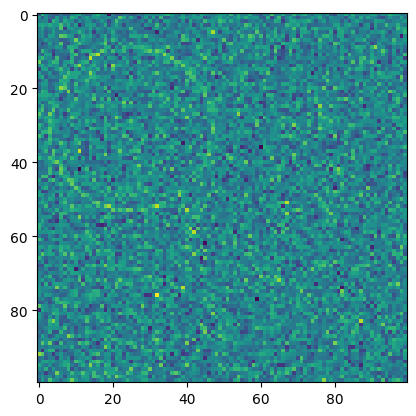

In [7]:
img=np.load("/content/train/images/0.npy")
plt.imshow(img)

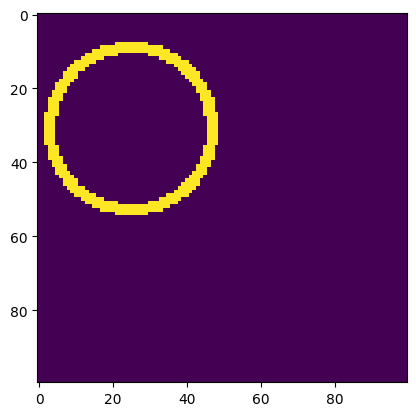

In [8]:
img=np.zeros((100,100))
f = open("/content/train/labels/0.txt", "r")
x=int(f.readline())
y=int(f.readline())
radius=int(f.readline())
cv2.circle(img, (x, y), int(radius), (255,0,0), 2)
plt.imshow(img)

## Trianing

Calculate mean and standard deviation on the triaining set for normalization, create the optimizer, loss, scheduler, and start training.

In [9]:
ls = []
for i in glob.glob("/content/train/images/*.npy"):
    ls.append(np.load(i, allow_pickle=True))
mean, std = np.mean(np.stack(ls)), np.std(np.stack(ls))

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean, mean, mean), (std, std, std))]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean, mean, mean), (std, std, std))]
)

batch_size = 10

dataset_stages = ["train", "val", "test"]
image_datasets = {
    "train": CustomDataset(
        files_train, loc_x_train, loc_y_train, radiuses_train, batch_size, transform
    ),
    "val": CustomDataset(
        files_valid,
        loc_x_valid,
        loc_y_valid,
        radiuses_valid,
        batch_size,
        test_transform,
    ),
    "test": CustomDataset(
        files_test, loc_x_test, loc_y_test, radiuses_test, batch_size, test_transform
    ),
}

dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=image_datasets[x].BatchSize,
        shuffle=False,
        num_workers=0,
    )
    for x in dataset_stages
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
model = models.shufflenet_v2_x1_0()
model.fc = nn.Linear(in_features=1024, out_features=3, bias=True)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, "min")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:

model, _ = train_model(
    model,
    dataloaders["train"],
    dataloaders["val"],
    criterion,
    optimizer,
    scheduler,
    device,
    50,
)


100%|██████████| 100/100 [00:02<00:00, 40.38it/s]


Epoch [0], train_loss: 0.0600, val_loss: 0.0062


100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


Epoch [1], train_loss: 0.0061, val_loss: 0.0053


100%|██████████| 100/100 [00:02<00:00, 40.28it/s]


Epoch [2], train_loss: 0.0032, val_loss: 0.0014


100%|██████████| 100/100 [00:02<00:00, 49.85it/s]


Epoch [3], train_loss: 0.0026, val_loss: 0.0062


100%|██████████| 100/100 [00:01<00:00, 51.30it/s]


Epoch [4], train_loss: 0.0028, val_loss: 0.0025


100%|██████████| 100/100 [00:02<00:00, 48.71it/s]


Epoch [5], train_loss: 0.0031, val_loss: 0.0053


100%|██████████| 100/100 [00:02<00:00, 46.62it/s]


Epoch [6], train_loss: 0.0020, val_loss: 0.0021


100%|██████████| 100/100 [00:02<00:00, 40.05it/s]


Epoch [7], train_loss: 0.0010, val_loss: 0.0017
Early stopping after 8 epochs without improvement.
Training complete in 5m 51s


In [11]:
model.load_state_dict(torch.load("/content/weights.pth"))
check_iou(model, dataloaders['test'], device)

0.991

In [12]:
ls=[]
for i in range(50,95,5):
  ls.append(check_iou(model, dataloaders['test'], device,i/100))
np.mean(ls)

0.8218333333333333

## Visualization

Plot some of the test images and reconstruct using model's predictions.

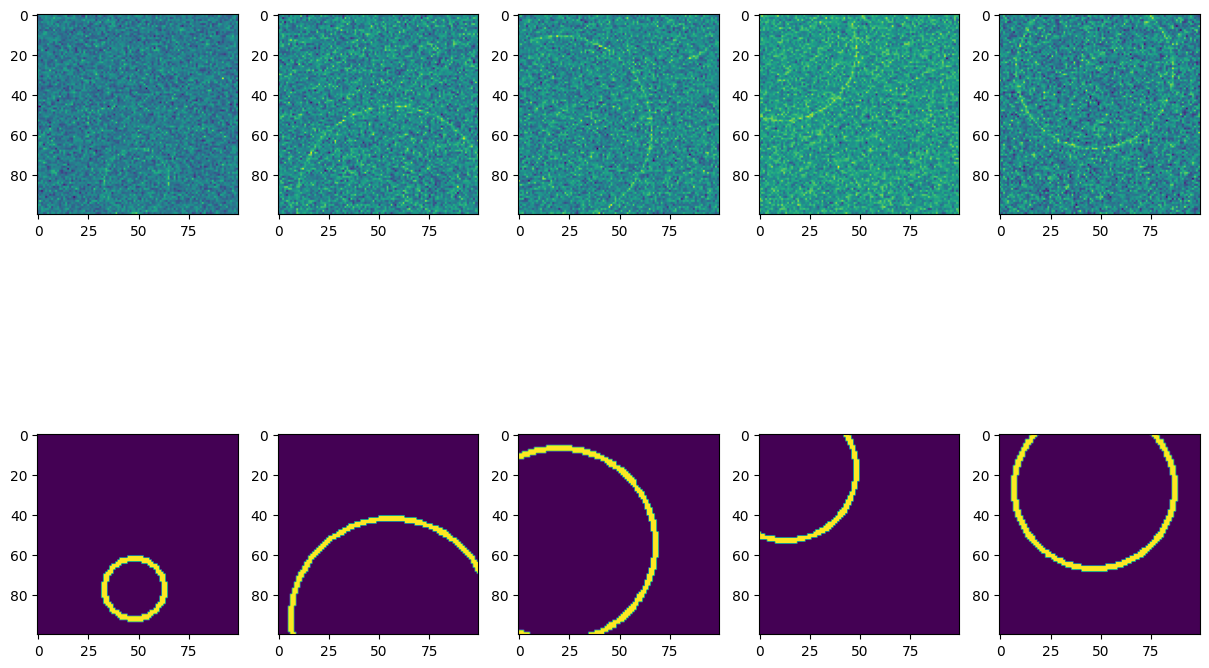

In [13]:
for images,_ in dataloaders['test']:
  break
pred=model(images.to("cuda").float())
fig,ax = plt.subplots(2,5, figsize=(15,10))
for i in range(5):
    ax[0][i].imshow(images[i,0])
    x,y,r=pred[i].detach().cpu().numpy()*[100,100,49]
    x,y,r=int(x),int(y),int(r)
    img=np.zeros((100,100))
    cv2.circle(img, (int(x), int(y)), int(r), (255,0,0), 2)
    ax[1][i].imshow(img)

## Sample Prediction on single generated image

In [15]:
from utils import noisy_circle, iou, CircleParams
img,param=noisy_circle(100,10,50,0.5)
img=(img-np.mean(img))/np.std(img)
pred=model(torch.from_numpy(np.tile(img.reshape(1,1,100,100),(1,3,1,1))).to("cuda").float())
col,row,radius=(pred*torch.from_numpy(np.asarray([[100,100,49]])).to("cuda")).detach().cpu().numpy()[0]
iou(CircleParams(int(row),int(col),int(radius)),param)

0.8889795918367347